# Crypto Factor Models and the Low Volatility Anomaly

### Scott Israel, PY538 Spring 2022

Can we build a factor model using a portfolio of cryptocurrencies? How does this model compare to factor models against stocks? Is it valid to treat cryptocurrencies as a stock-like financial asset? According to a team at the National Bureau of Economic Research in Cambridge, MA, we can. They developed a 3-factor model composed of a crypto market factor, crypto momentum factor, and crypto size factor. I will try to recreate those factors and analyze their results. Additionally I will test if cryptos exhibit the low volatility anomaly, which would more closely correlate them with traditional stocks (it wouldn't equate them though).

My datasets consist of pricing data from yahoo finance and market cap data from coinmarketcap.com. Unfortunately most historical market cap data is locked behind a paywall, so I only used the market cap data from the day I accessed their API, April 8th, 2022. I tried remedying this with a rolling Markowitz optimization year-to-year to try and backfill the market caps based off of the maximum Sharpe ratio but there were convergence issues. Check out cryptoMarkowitz.py for a working optimization using a smaller dataset.

I have useful results for the momentum factor and the low volatility anomaly. The crypto size factor was unusable due to the Markowitz divergence, and the crypto market factor was disappointing due to the poor performance. That would also match up well with current trends showing that crypto is on a downward trend as of the first half of 2022. The correlation between BTC and QQQ is dragging the entire crypto market with it. Few investors would win as things are now, unless one managed to short the 'crypto market' years ago. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from requests import Request, Session
import json
import pandas as pd
import yfinance as yf
from datetime import datetime

In [ ]:
# Importing market cap data for RIGHT NOW
# Get your own API key please

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

parameters = {
    'start':'1',
    'convert':'USD'
    }

headers = {
    'Accepts':'application/json',
    'X-CMC_PRO_API_KEY':'<Insert your own API key>'
    }

session = Session()
session.headers.update(headers)

response = session.get(url,params=parameters)
data = json.loads(response.text)

df_coinmarketcap = pd.DataFrame.from_records(data['data'])
df_coinmarketcap['Market Cap'] = df_coinmarketcap.quote[0]['USD']['price'] * df_coinmarketcap['circulating_supply']

crypto_list = df_coinmarketcap.symbol + '-USD'

crypto_weights = df_coinmarketcap['Market Cap']

In [45]:
# Getting pricing data

start = datetime(2017, 1, 1)
end = datetime(2022, 4, 8)
#end = datetime.now().date().isoformat()

symbols = pd.read_csv('crypto_list.csv') # I saved these on April 8th, see the API cell for current data
weights = pd.read_csv('crypto_weights.csv')

total_mkt = weights.sum()

# Creating the dataframe from pricing data
df = pd.concat([yf.download(crypto[0], start=start, end=end) for crypto in symbols.values], axis=1)

dataframes = pd.DataFrame()

for i in range(4, df.shape[1], 6):
     dataframes[i] = df.iloc[:,i].pct_change()
    
dataframes.columns = symbols
dataframes.fillna(0, inplace=True)
dataframes.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,"(BTC-USD,)","(ETH-USD,)","(USDT-USD,)","(BNB-USD,)","(USDC-USD,)","(XRP-USD,)","(SOL-USD,)","(ADA-USD,)","(LUNA-USD,)","(AVAX-USD,)",...,"(HOT-USD,)","(ROSE-USD,)","(DCR-USD,)","(SCRT-USD,)","(AUDIO-USD,)","(KAVA-USD,)","(KNC-USD,)","(ANC-USD,)","(QTUM-USD,)","(BORA-USD,)"
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,0.023464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.021620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,0.106233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,-0.122410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that many of cryptocurrencies did not have a return in 2017, with non-zero data later in the time range. The following applies market caps weights only on April 8th, in case there are any issues with the Markowitz optimization.

In [48]:
# To get a total return for the top 100 coins, I use the following code:
# Apply weights to crypto data

dataframes['Total'] = [(np.dot(weights.values.flatten(),dataframes.iloc[i,:].values) / total_mkt.values)[0] for i in range(dataframes.shape[0])] 

m = dataframes.loc[dataframes['Total'] != np.inf, 'Total'].max()
dataframes['Total'].replace(np.inf,dataframes.Total.median(),inplace=True)

## Markowitz Portfolio Optimization

To get the weights, we use a Markowitz optimization. Otherwise we'd use the market cap data to weight each crypto. Unfortunately market cap data is locked behind a paywall, as all good things are. The following function finds the minimum voltatility weights for a specified rate of return. 



In [32]:
from scipy.optimize import minimize

# Function to find the minimum variance given a desired return.
def min_variance(mu, cov, desired_ret):

    # Compute the variance
    def variance(weights):
        return np.dot(weights, np.dot(cov, weights))

    # Check that the weights sum up to 1
    def check_sum(weights):
        return np.sum(weights) - 1

    # Check that the return of the portfolio is the desired return.
    def check_return(weights):
        return desired_ret - np.dot(mu.T,weights)

    # Write down the constraints as equality constraints.
    cons = ({"type": "eq", "fun": check_sum},
            {"type": "eq", "fun": check_return})

    # We are guessing a purposely wrong initial guess.
    init_guess = [-10 for _ in range(len(mu))]

    # Run the minimiziation
    results = minimize(variance, x0=init_guess, constraints=cons, tol=1e-4)

    w = results.x

    # Assert that the optimization converged. Otherwise, throw an error.
    assert results.success, "Optimization did not converge for : " + \
        str(desired_ret)

    # Return the desired return and variance of the appropriate portfolio.
    return [desired_ret, variance(w), w]

The following cell sets a random weight for each of the 100 cryptos for each day. I used the Dirichlet distribution because with the parameters I chose the weights for each day sum to 1, as they should.

In [28]:
dummy = np.ones((dataframes.shape[0],100))
rw_df = pd.DataFrame(data=dummy, columns=symbols)

for i in range(0,100):
    for j in range(dataframes.shape[0]):
        if (dataframes.iloc[j,i] != 0.0):
            new_weights = np.random.dirichlet(np.ones(len(symbols)), size=1)
            rw_df.iloc[j,i] = new_weights[0,i]
        else: 
            rw_df.iloc[j,i] = 0.0


In [22]:
rw_df.tail()

,"(BTC-USD,)","(ETH-USD,)","(USDT-USD,)","(BNB-USD,)","(USDC-USD,)","(XRP-USD,)","(SOL-USD,)","(ADA-USD,)","(LUNA-USD,)","(AVAX-USD,)",...,"(HOT-USD,)","(ROSE-USD,)","(DCR-USD,)","(SCRT-USD,)","(AUDIO-USD,)","(KAVA-USD,)","(KNC-USD,)","(ANC-USD,)","(QTUM-USD,)","(BORA-USD,)"
2044,0.001274,0.003342,0.005285,0.003882,0.009169,0.003952,0.003004,0.008041,0.0,0.046620,...,0.006645,0.016560,0.000849,0.006368,0.014686,0.008285,0.025619,0.005777,0.012625,0.002827
2045,0.001926,0.002888,0.006410,0.009747,0.013849,0.004325,0.011640,0.003229,0.0,0.001274,...,0.004670,0.005485,0.017729,0.016897,0.009638,0.001454,0.024506,0.012881,0.002594,0.002875
2046,0.015009,0.007602,0.003712,0.011971,0.014870,0.012267,0.082367,0.002903,0.0,0.011792,...,0.000186,0.016190,0.019028,0.003322,0.004227,0.008348,0.000063,0.019529,0.000944,0.007134
2047,0.044697,0.004760,0.011173,0.006867,0.025641,0.004471,0.003991,0.017915,0.0,0.014526,...,0.001635,0.004679,0.000116,0.001804,0.002972,0.000834,0.006154,0.000514,0.006799,0.002234
2048,0.003343,0.019498,0.004558,0.000093,0.028443,0.004830,0.063261,0.002706,0.0,0.015698,...,0.000882,0.007002,0.006561,0.004636,0.007106,0.005665,0.002882,0.024369,0.017980,0.007123


In [34]:
# Average drift term
mu_df = dataframes.mean()
max_value = np.nanmax(mu_df[mu_df != np.inf])
mu_df.replace([np.inf, -np.inf], max_value, inplace=True)
mu = mu_df.values

# Covariance
cov_df = dataframes.cov()
max_value = np.nanmax(cov_df[cov_df != np.inf])
cov_df.replace([np.inf, -np.inf], max_value, inplace=True)
cov = cov_df.values

# Compute the expected return of the portfolio for each random set.
random_portfolio_df = rw_df.dot(mu).to_frame("R_P")
# Compute the variance of the portfolio for each random set.
random_portfolio_df["Var"] = np.sum(rw_df.dot(cov.dot(rw_df.T) ), axis=1)
random_portfolio_df["SD"] = np.sqrt(random_portfolio_df['Var'])

print(cov)
print(mu)

C:\Users\Scott\anaconda3\lib\site-packages\numpy\lib\function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


[[ 1.71063566e-03  1.35412058e-03  3.97075412e-06 ...  1.69619476e-03
   1.53989710e-03  7.06501360e-04]
 [ 1.35412058e-03  2.23061205e-03 -1.77861689e-06 ...  2.42348069e-03
   2.15369559e-03  1.01498518e-03]
 [ 3.97075412e-06 -1.77861689e-06  1.84574238e-05 ...  2.52517093e-05
  -5.80723332e-06 -7.33632326e-06]
 ...
 [ 1.69619476e-03  2.42348069e-03  2.52517093e-05 ...  6.65561371e-02
   2.37552417e-03  9.75552791e-04]
 [ 1.53989710e-03  2.15369559e-03 -5.80723332e-06 ...  2.37552417e-03
   4.52064158e-03  1.33044014e-03]
 [ 7.06501360e-04  1.01498518e-03 -7.33632326e-06 ...  9.75552791e-04
   1.33044014e-03  1.36878719e-02]]
[ 2.42206742e-03  2.00098550e-03  5.39021567e-06  4.05537313e-03
  4.08601721e-06  2.10181446e-03  3.23135289e-03  3.52018403e-03
  1.45629104e-01  1.97582223e-03  5.11958064e-03  1.46167829e-03
  2.84098974e-06 -2.81917665e-04  1.45629104e-01  1.47114410e-03
  1.89947961e-03  4.87109346e-03  2.56321343e-03  1.78652309e-05
  3.08039512e-03  1.86059706e-03  4.033

# Factor Models

$$
R_i - R_f = \alpha^i + \beta^i_{CMKT}CMKT + \beta^i_{CSMB}CSMB + \beta^i_{CMOM}CMOM
$$

## Crypto Market Factor CMKT

According to Liu et al., we can measure the crypto market return, our CMKT factor, as the difference between the total crypto currency returns and the one month US treasury bill rate. We can observe this below, plotted between 2017 and April 2022.

In [49]:
#One month treasury bill rate
risk_free = pd.read_csv('USTreasury1Mon.csv', index_col=0, parse_dates=True)

In [42]:
test = min_variance(mu,cov,desired_rets[-1])

AssertionError: Optimization did not converge for : 0.0004931506849315068

The following cell calculates the maximum Sharpe ratio to find the optimum set of portfolio weights for the dataset. 

In [63]:
'''
desired_rets = np.linspace(0.01/365, 0.18/365, 171)

frontier = [min_variance(mu, cov, desired_ret)
            for desired_ret in desired_rets]

frontier_df = pd.DataFrame(data=frontier, columns=["ER", "Var", "Weights"])

frontier_df['SD'] = np.sqrt(frontier_df.Var)

frontier_df['SR'] = (frontier_df.ER - risk_free[' Close'].pct_change()) / frontier_df.SD

max_sharpe = frontier_df.loc[frontier_df["SR"] == np.max(frontier_df["SR"])]
'''

'\ndesired_rets = np.linspace(0.01/365, 0.18/365, 171)\n\nfrontier = [min_variance(mu, cov, desired_ret)\n            for desired_ret in desired_rets]\n\nfrontier_df = pd.DataFrame(data=frontier, columns=["ER", "Var", "Weights"])\n\nfrontier_df[\'SD\'] = np.sqrt(frontier_df.Var)\n\nfrontier_df[\'SR\'] = (frontier_df.ER - risk_free[\' Close\'].pct_change()) / frontier_df.SD\n\nmax_sharpe = frontier_df.loc[frontier_df["SR"] == np.max(frontier_df["SR"])]\n'

In [31]:
print(max_sharpe)

Empty DataFrame
Columns: [ER, Var, Weights, SD, SR]
Index: []


Running the above Markowitz leads to convergence errors. Because of infinite-valued returns, stemming from missing data, this does not work as intended. I was not able to solve this problem in time for the classroom deadline, but maybe a future debugging session can lead to more interesting, and workable, results. Backfilling did not solve the problem either (as of April 28th, 2022).

Average market return annually:  -2.7060865757905797
Median market return annually:  0.0


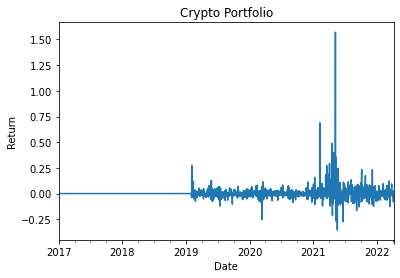

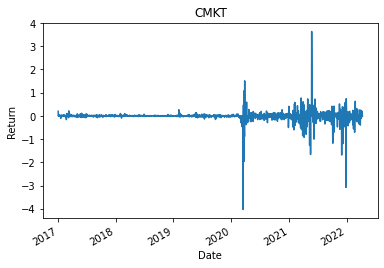

In [61]:
plt.figure(1)
dataframes.Total.plot(ylabel='Return',title='Crypto Portfolio')

crypto_mean = dataframes.mean()
crypto_std = dataframes.std()

# CMKT factor calculation
cmkt = dataframes.Total - risk_free[' Close'].pct_change()

#Filling any NaNs with 0
cmkt.fillna(0, inplace=True)

avg_cmkt_ann = cmkt.mean() * 365

plt.figure(2)
cmkt.plot(ylabel='Return',title='CMKT')

avg_cmkt_ann = cmkt.mean() * 365
print('Average market return annually: ', avg_cmkt_ann)

med_cmkt_ann = cmkt.median() * 365
print('Median market return annually: ', med_cmkt_ann)

The overall crypto market has not been doing well, as shown by the average and median return. Keep in mind though that the crypto weights are based off of the market cap from April 2022 and may not accurately represent cryptos introduced recently.

## Crypto Momentum Factor CMOM

The momtemtum factor in Liu et al's study is constructed similarly to the momentum factor in the stock market. We are using the simplified approach where we consider the 11 preceding months of returns for each crypto and "buying past winners, selling past losers." In particular, we consider the 30 best performing cryptos and the 30 worst performing cryptos. 

Average momentum return annually:  0.3227568031368629
Median momentum return annually:  0.0


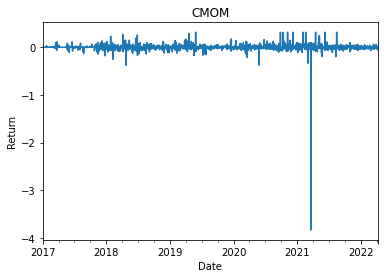

In [60]:
# Crypto Momentum Factor

# Looking at the 11 preceding months
rolling_crypto = dataframes.rolling(11).sum().shift()

# Ranking the cryptos
ranked_crypto_mom = rolling_crypto.rank(axis=1)

# Separating into low and high momentum groups for the 30 best and worst cryptos
low_mom = dataframes.where(ranked_crypto_mom < 0.30*100).mean(axis=1)
high_mom = dataframes.where(ranked_crypto_mom > (1-0.30)*100).mean(axis=1)

# Calculating the momentum factor as the high-low difference and removing infinite values
cmom_df = high_mom - low_mom
cmom_df.fillna(0,inplace=True)
max_value = np.nanmax(cmom_df[cmom_df != np.inf])
cmom_df.replace([np.inf, -np.inf], max_value, inplace=True)

plt.figure(3)
cmom_df.plot(ylabel='Return',title='CMOM')

avg_cmom_ann = cmom_df.mean() * 365
print('Average momentum return annually: ', avg_cmom_ann)

med_cmom_ann = cmom_df.median() * 365
print('Median momentum return annually: ', med_cmom_ann)

The momentum factor performed decently well, all things considered. The drop in 2021 is likely due to the crash when BTC dropped from ~$68k and the altcoins followed.

## Crypto Small Minus Big Factor CSMB

Finally our small-minus-big factor is constructed by taking the 30 largest cryptos, weighted by market cap, and our 30 smallest cryptos, also weighted by market cap, and subtracting them.

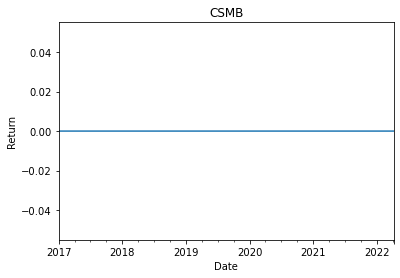

In [62]:
# Crypto SMB factor
weights.index = symbols
ranked_crypto_smb = weights.rank(axis = 0)

low_smb = dataframes.where(ranked_crypto_smb < 0.30*100).mean(axis=1)
high_smb = dataframes.where(ranked_crypto_smb > (1-0.30)*100).mean(axis=1)

csmb_df = high_smb - low_smb
csmb_df.fillna(0,inplace=True)

plt.figure(4)
csmb_df.plot(ylabel='Return', title='CSMB')

avg_csmb_ann = csmb_df.mean() * 365

The CSMB factor only has a single constant value because the Markowitz optimization did not converge, leading to a single set of weights that does not change based on the market caps of the top 100 cryptos as of April 8th, 2022. With just a constant value the CSMB factor will just combine with the constant $\alpha^i$ to form $\alpha'^i= \alpha^i + \beta^i_{CSMB}CSMB$, which is another constant.

## Complete Crypto 3-Factor Model

Since there were persistent issues with the Markowitz optimization, none of the conclusions involving the crypto 3 factor model will be of any use, since the CSMB factor is becomes a constant. We are then left with a two factor model, which according to Liu et al., is not statistically significant in any advantages we may want. Compared to Liu's analysis, CMKT and CMOM are behaving similarly, with some oddities in the spring of 2021, likely due to the significant changes in 'meme-coins' such as Dogecoin. If CSMB shows similar behavior to Liu et al's analysis, it can be safe to conclude that their conclusions hold over time. Of course, there will always be some range of uncertainty that will put a threshold on one's conclusions.   

# Low-Volatility Anomaly

In investing, low-volatility stocks have been observed to have higher returns than stiocks with higher volatility on average. This is known as the low-volatility anomaly. Using the same data from the previous section, let's now see if the low-volatility anomaly persists among a portfolio of the top 100 cryptos as of April 8th, 2022. We split the cryptos into groups of 10 based on their volatility. Then we calculate the mean volatility and return of each group and plot them against each other. Luckily we don't need proper market cap data and weights to do this calculation, so the dubious CSMB factor won't skew our estimates.

In [14]:
import statsmodels.regression.linear_model as sm

In [15]:
# Low volatility Anomaly
cryptos_df = dataframes.drop("Total", axis=1)
crypto_std = cryptos_df.std(axis=0)
ranked_cryptos = crypto_std.sort_values()
groups = np.split(ranked_cryptos, 10)

In [16]:
returns = []
for i in range(len(groups)):
    returns.append(cryptos_df.loc[:,groups[i].index].mean(axis=1))

returns = np.array(returns)

C:\Users\Scott\anaconda3\lib\site-packages\numpy\core\_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


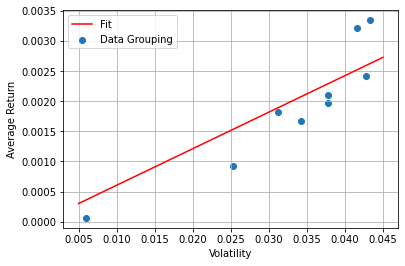

Slope:  0.06058347966559846


In [17]:
avg_ret = []
std_ret = []

for i in range(len(returns)):
    avg_ret.append(returns[i].mean())
    std_ret.append(returns[i].std())

plt.scatter(std_ret,avg_ret,label='Data Grouping')
plt.xlabel('Volatility')
plt.ylabel('Average Return')
plt.grid()


avg_ret.pop(-1)
std_ret.pop(-1) 

model = sm.OLS(avg_ret, std_ret).fit()

plt.plot(np.linspace(0.005,0.045,100),np.linspace(0.005,0.045,100)*model.params[0], color='red', label='Fit')
plt.legend()
plt.show()

print('Slope: ', model.params[0])

With a positive slope, this is the opposite behavior of a well-diversified stock portfolio, which has a negative slope. That is where the low-volatility anomaly comes from.
From this analysis, **the low volatility anomaly is not present in cryptocurrenices**, which, while disappointing, is not surprising. As crypto is such a new and unexplored asset class, there is little reason to believe they will behave identically to traditional stock portfolios. The last group is not plotted since it contains infinite values, but that does not take away from my conclusion. 

# Conclusion

Even without a working Markowitz optimization, we have answered the hypothesis of the low-volatility anomaly: for cryptos it does not exist. The calculation is independent of any weights since we are dropping the `dataframes['Total']` column. In a further study, continuing from this work, we may be able to extract more useful data about the crypto 3-factor model.

Addendum September 3rd, 2022: I would like to come back to this in the future to fix the Markowitz and properly examine the factors. Perhaps my conclusions will change on the factor model.

# Bibliography

```{bibliography}
 @misc{journal, title={TMUBMUSD01M | U.S. 1 month Treasury Bill Historical prices - WSJ}, url={https://www.wsj.com/market-data/quotes/bond/BX/TMUBMUSD01M/historical-prices}, journal={The Wall Street Journal}, publisher={Dow Jones &amp; Company}, author={Journal, Wall Street}} 
 @misc{liu_tsyvinski_wu_2019, title={Common risk factors in cryptocurrency - NBER}, url={https://www.nber.org/system/files/working_papers/w25882/w25882.pdf}, publisher={National Bureau of Economic Research}, author={Liu, Yukun and Tsyvinski, Aleh and Wu, Xi}, year={2019}, month={May}} 
```